## Implementation using TensorFlow

Previously having implemented this using FastAI, although not the best is still functional, I have decided to use TensorFlow to implement this again, to allow me to be more flexible and learn more about this framework. After a lot of learning I am now at a point in understanding where creating this model shouldnt be too difficult. This project will be split into 4 parts:
* Loading and preparing the data
* Creation and compilation of the model
* Training the model
* Creating the agent (this time not in the notebook!)

### Library imports

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os, warnings
from PIL import Image

import os
import sys
import math

from pathlib import Path

# matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

### Part 1 - Loading the Data

In [2]:
tf.random.set_seed(42)

In [3]:
def get_frames(frames_path):
    files = os.listdir(frames_path)
    print("Number of files in the path is : ", len(files))

    frame_list = []
    for i in range(len(files)):
        frame_name = 'frame-'+str(i)+".jpg"
        file = os.path.join(frames_path, frame_name)
        frame_list.append(file)
        # print(file)
        # print(os.path.exists(file))
        # cnt +=1
        # if cnt>=10:
        #   break
    return frame_list

In [4]:
coordinates = pd.read_csv("C:/Users/Joshua/Desktop/Projects/Python/osu-ai/osu-ai/data/coordinates.csv")
print("Coordinates of first dataset")
print(coordinates.head())

Coordinates of first dataset
       x      y
0  46.40  13.90
1  46.55  13.35
2  46.40  13.20
3  46.40  13.20
4  46.55  13.30


In [7]:
def get_coordinates_with_frame_name(coordinates, frames_path):
    frame_list = get_frames(frames_path)
    assert (len(frame_list) == len(coordinates)), "Number of frames and co-ordinates must be equal"
    coordinates.insert(0, 'frame', frame_list )
    return coordinates

In [8]:
coordinates = get_coordinates_with_frame_name(coordinates, "C:/Users/Joshua/Desktop/Projects/Python/osu-ai/osu-ai/data/frames")
print(coordinates.head())

Number of files in the path is :  7770
                                               frame      x      y
0  C:/Users/Joshua/Desktop/Projects/Python/osu-ai...  46.40  13.90
1  C:/Users/Joshua/Desktop/Projects/Python/osu-ai...  46.55  13.35
2  C:/Users/Joshua/Desktop/Projects/Python/osu-ai...  46.40  13.20
3  C:/Users/Joshua/Desktop/Projects/Python/osu-ai...  46.40  13.20
4  C:/Users/Joshua/Desktop/Projects/Python/osu-ai...  46.55  13.30


### Part 2 - Processing the Data (Dataloaders)

In [20]:
from skimage.io import imread
from skimage.transform import resize

In [21]:
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class TrainDataSequence(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size):
        self.batch_size = batch_size
        self.df = df

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.df['frame'][idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y1 = self.df['x'][idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y2 = self.df[' y'][idx * self.batch_size:(idx + 1) *
        self.batch_size]

        frames = []
        positions = []
        for frame, x, y in zip(batch_x, batch_y1,batch_y2):
            frame_img = resize(imread(frame), (60,80,1))
            frames.append(frame_img)
            positions.append([x,y])

        return np.array(frames), np.array(positions)

In [22]:
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class TestDataSequence(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size):
        self.batch_size = batch_size
        self.df = df

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.df['frame'][idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y1 = self.df['x'][idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y2 = self.df[' y'][idx * self.batch_size:(idx + 1) *
        self.batch_size]

        frames = []
        positions = []
        for frame, x, y in zip(batch_x, batch_y1,batch_y2):
            frame_img = resize(imread(frame), (60,80,1))
            frames.append(frame_img)
            positions.append([x,y])

        return np.array(frames), np.array(positions)


### Part 3 - Creation and compilation of Model

In [29]:
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 80,1),))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='linear'))

In [36]:
print("[INFO] compiling model...")
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# metrics=tf.keras.metrics.mean_absolute_error

[INFO] compiling model...


In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 78, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 37, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 16, 32)        18464     
                                                                 
 flatten_2 (Flatten)         (None, 5632)             

### Part 4 - Training the Model

In [43]:
train_sequence =  TrainDataSequence(coordinates[:5000],batch_size = 32)
# print(*train_sequence)
test_sequence =  TestDataSequence(coordinates[5000:],batch_size = 32)

Create a callback function for the model to stop overfitting

In [ ]:
history = model.fit(train_sequence, validation_data = test_sequence, epochs = 10, verbose=1)

Epoch 1/10
157/157 [==============================] - 16s 101ms/step - loss: 7.3447 - val_loss: 6.8406
Epoch 2/10
157/157 [==============================] - 15s 95ms/step - loss: 7.4085 - val_loss: 6.8389
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 7.4197 - val_loss: 6.8432
Epoch 4/10
157/157 [==============================] - 14s 90ms/step - loss: 7.4475 - val_loss: 6.8405
Epoch 5/10
157/157 [==============================] - 14s 88ms/step - loss: 7.4224 - val_loss: 6.8366
Epoch 6/10
157/157 [==============================] - ETA: 0s - loss: 7.4543

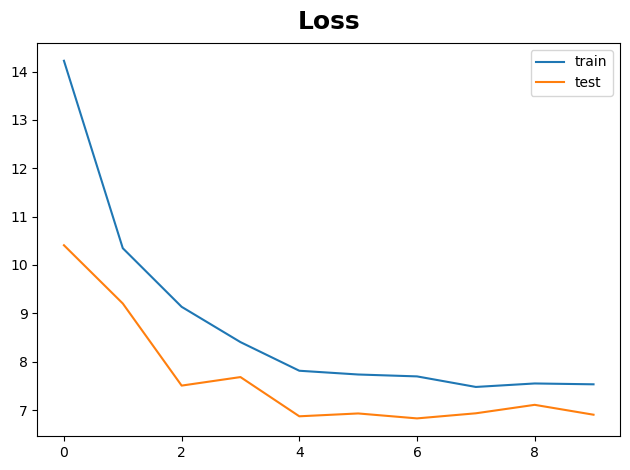

In [46]:
# epoch vs loss graph
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [47]:
def make_prediction(img_path):
    img = resize(imread(img_path), (60,80,1))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    print(pred)

    return pred

In [ ]:
img_path = ""
pred = make_prediction(img_path)